In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader

from train.Dataset import CustomDataset
from train.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from train.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

In [4]:
print(x_train.shape)
print(x_val.shape)

(15407, 60, 9)
(2202, 60, 9)


(15407, 60, 9) (4403, 60, 9) (2202, 60, 9)


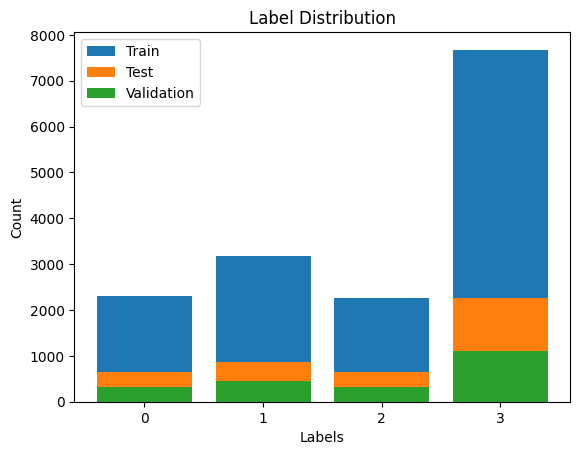

In [5]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

# Streamlined Train + Test Process

In [11]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard
# %reload_ext tensorboard
!taskkill /F /IM tensorboard.exe

ERROR: The process "tensorboard.exe" not found.


In [6]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

def streamline_train_and_test(Autoencoder, tag, early_stop, dropout_rate, num_epochs, lr_rate):
    ### Streamlined training of model + SVM ###
    encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'
    train_losses, val_losses = train_model(Autoencoder, train_dataloader, val_dataloader, val_dataset, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
    plot_loss_graph(train_losses, val_losses, tag)
    encoded_data, labels = encode_data(train_dataloader, dataset_ver, tag, encoder_ver)
    svm_classifier = train_svm(encoded_data, labels.ravel(), dataset_ver, tag, encoder_ver)
    ### Streamlined testing of model + SVM ###
    test_labels, test_predictions = test_model(test_dataloader, dataset_ver, tag, encoder_ver)
    calculate_accuracy(test_labels, test_predictions, tag)

# LSTM Models

In [10]:
# Unidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x, (encoded_x, _) = self.LSTM1(x)
        encoded_x = self.dropout(encoded_x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (output): Linear(in_features=360, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0353, Val Loss: 0.0286
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0194, Val Loss: 0.0192
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0106, Val Loss: 0.0112
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0084, Val Loss: 0.0093
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0066, Val Loss: 0.0086
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0076, Val Loss: 0.0074
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0058, Val Loss: 0.0068
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0079, Val Loss: 0.0065
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0061, Val Loss: 0.0061
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0060, Val Loss: 0.0055
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0040, Val Loss: 0.0054
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0059, Val Loss: 0.0054
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0046, Val Loss: 0.0046
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0044, Val Loss: 0.0045
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0032, Val Loss: 0.0046
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0040, Val Loss: 0.0043
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0035, Val Loss: 0.0039
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0034, Val Loss: 0.0038
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0035, Val Loss: 0.0037
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0042, Val Loss: 0.0035
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0035, Val Loss: 0.0036
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0023, Val Loss: 0.0036
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0033, Val Loss: 0.0033
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0028, Val Loss: 0.0033
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0041, Val Loss: 0.0034
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0030, Val Loss: 0.0030
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0024, Val Loss: 0.0031
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0033, Val Loss: 0.0030
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0033, Val Loss: 0.0028
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0029, Val Loss: 0.0030
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0019, Val Loss: 0.0028
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0027, Val Loss: 0.0029
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0035, Val Loss: 0.0027
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0023, Val Loss: 0.0027
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0025, Val Loss: 0.0026
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0021, Val Loss: 0.0026
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0025, Val Loss: 0.0026
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0025, Val Loss: 0.0026
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0022, Val Loss: 0.0024
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0026, Val Loss: 0.0023
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0019, Val Loss: 0.0023
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0023, Val Loss: 0.0024
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0028, Val Loss: 0.0025
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0018, Val Loss: 0.0023
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0022, Val Loss: 0.0024
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0018, Val Loss: 0.0023
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0020, Val Loss: 0.0022
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0017, Val Loss: 0.0022
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0021, Val Loss: 0.0022
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0022, Val Loss: 0.0021


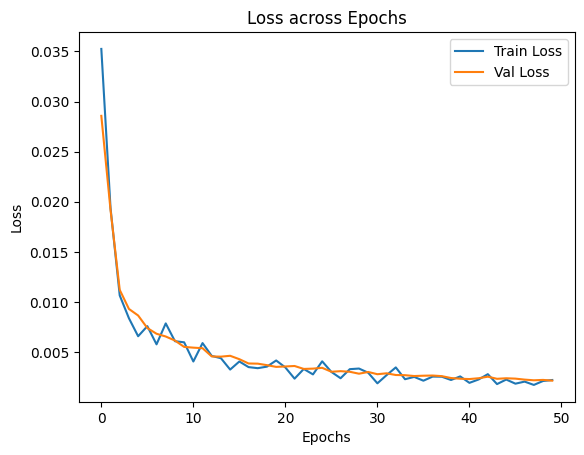

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9085009733939


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 91.55%


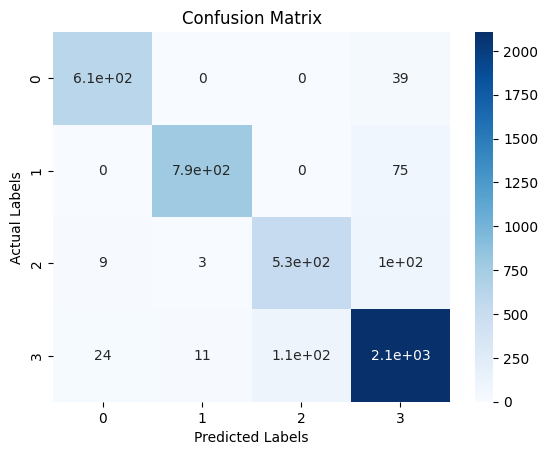

In [11]:
streamline_train_and_test(Autoencoder, tag="lstm_run_1", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

In [12]:
# Unidirectional 2-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.output = nn.Linear(self.hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 720, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0332, Val Loss: 0.0338
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0214, Val Loss: 0.0223
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0116, Val Loss: 0.0117
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0132, Val Loss: 0.0120
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0065, Val Loss: 0.0078
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0057, Val Loss: 0.0074
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0083, Val Loss: 0.0065
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0070, Val Loss: 0.0064
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0040, Val Loss: 0.0060
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0046, Val Loss: 0.0058
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0033, Val Loss: 0.0052
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0049, Val Loss: 0.0052
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0057, Val Loss: 0.0052
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0043, Val Loss: 0.0045
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0033, Val Loss: 0.0045
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0047, Val Loss: 0.0040
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0046, Val Loss: 0.0039
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0030, Val Loss: 0.0036
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0041, Val Loss: 0.0038
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0041, Val Loss: 0.0041
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0025, Val Loss: 0.0037
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0037, Val Loss: 0.0036
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0035, Val Loss: 0.0033
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0033, Val Loss: 0.0035
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0023, Val Loss: 0.0031
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0030, Val Loss: 0.0030
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0031, Val Loss: 0.0031
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0022, Val Loss: 0.0029
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0021, Val Loss: 0.0029
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0027, Val Loss: 0.0033
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0025, Val Loss: 0.0028
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0045, Val Loss: 0.0029
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0023, Val Loss: 0.0026
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0025, Val Loss: 0.0027
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0028, Val Loss: 0.0028
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0033, Val Loss: 0.0028
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0022, Val Loss: 0.0026
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0024, Val Loss: 0.0026
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0019, Val Loss: 0.0025
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0021, Val Loss: 0.0025
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0022, Val Loss: 0.0024
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0020, Val Loss: 0.0024
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0022, Val Loss: 0.0025
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0025, Val Loss: 0.0024
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0020, Val Loss: 0.0025
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0015, Val Loss: 0.0023
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0018, Val Loss: 0.0023
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0023, Val Loss: 0.0023
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0018, Val Loss: 0.0024
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0019, Val Loss: 0.0022


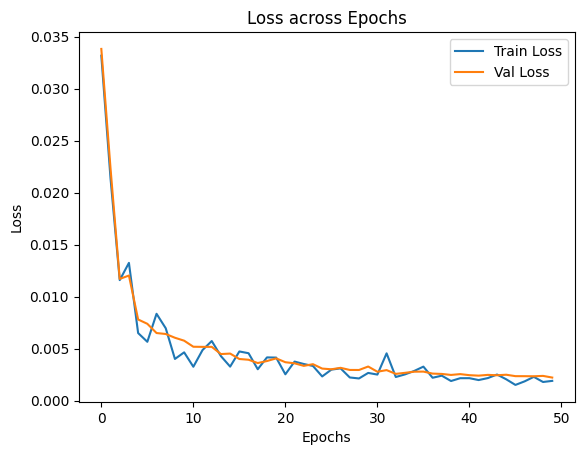

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9013627514600908


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 90.46%


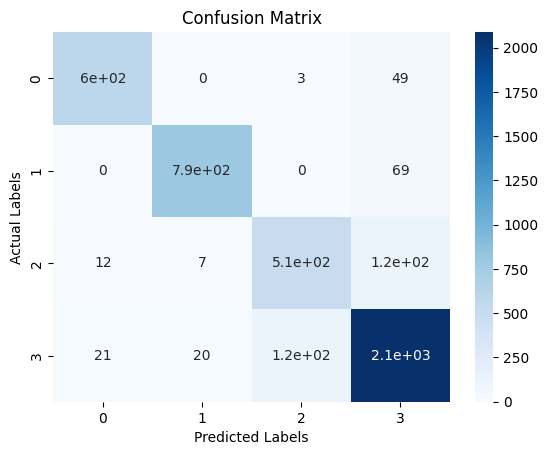

In [13]:
streamline_train_and_test(Autoencoder, tag="lstm_run_3", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

In [27]:
# Bidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0383, Val Loss: 0.0289
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0168, Val Loss: 0.0133
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0144, Val Loss: 0.0104
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0106, Val Loss: 0.0083
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0054, Val Loss: 0.0076
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0072, Val Loss: 0.0067
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0050, Val Loss: 0.0064
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0088, Val Loss: 0.0069
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0083, Val Loss: 0.0052
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0054, Val Loss: 0.0051
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0067, Val Loss: 0.0046
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0044, Val Loss: 0.0043
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0037, Val Loss: 0.0041
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0047, Val Loss: 0.0041
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0037, Val Loss: 0.0041
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0031, Val Loss: 0.0038
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0032, Val Loss: 0.0040
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0031, Val Loss: 0.0034
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0062, Val Loss: 0.0048
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0039, Val Loss: 0.0033
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0034, Val Loss: 0.0032
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0035, Val Loss: 0.0031
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0023, Val Loss: 0.0038
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0029, Val Loss: 0.0028
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0027, Val Loss: 0.0032
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0021, Val Loss: 0.0026
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0020, Val Loss: 0.0026
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0024, Val Loss: 0.0026
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0027, Val Loss: 0.0026
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0022, Val Loss: 0.0025
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0025, Val Loss: 0.0024
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0018, Val Loss: 0.0023
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0019, Val Loss: 0.0023
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0024, Val Loss: 0.0024
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0023, Val Loss: 0.0022
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0017, Val Loss: 0.0023
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0019, Val Loss: 0.0022
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0023, Val Loss: 0.0021
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0018, Val Loss: 0.0023
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0021, Val Loss: 0.0023
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0020, Val Loss: 0.0020
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0022, Val Loss: 0.0020
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0022, Val Loss: 0.0022
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0020, Val Loss: 0.0021
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0015, Val Loss: 0.0021
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0020, Val Loss: 0.0020
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0019, Val Loss: 0.0020
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0017, Val Loss: 0.0019
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0016, Val Loss: 0.0019
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0014, Val Loss: 0.0018


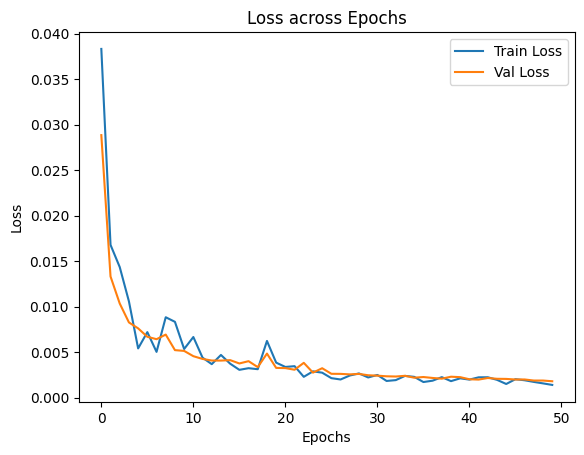

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9153147306943543


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 91.73%


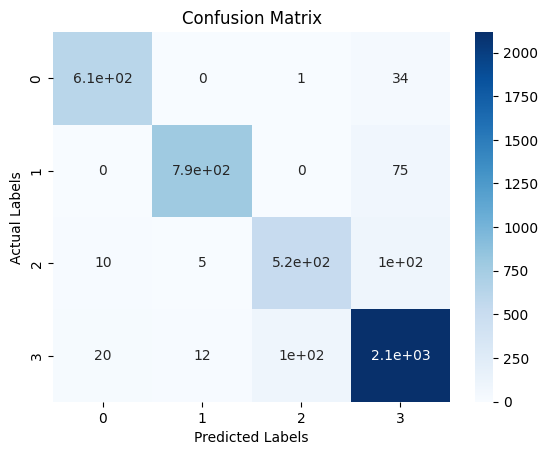

In [15]:
streamline_train_and_test(Autoencoder, tag="lstm_run_2", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0347, Val Loss: 0.0294
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0142, Val Loss: 0.0149
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0106, Val Loss: 0.0108
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0122, Val Loss: 0.0098
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0082, Val Loss: 0.0082
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0066, Val Loss: 0.0079
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0133, Val Loss: 0.0072
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0074, Val Loss: 0.0069
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0057, Val Loss: 0.0060
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0059, Val Loss: 0.0061
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0083, Val Loss: 0.0060
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0066, Val Loss: 0.0056
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0062, Val Loss: 0.0052
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0053, Val Loss: 0.0057
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0055, Val Loss: 0.0051
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0054, Val Loss: 0.0048
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0046, Val Loss: 0.0047
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0051, Val Loss: 0.0045
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0043, Val Loss: 0.0044
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0051, Val Loss: 0.0043
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0030, Val Loss: 0.0043
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0051, Val Loss: 0.0043
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0041, Val Loss: 0.0042
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0046, Val Loss: 0.0040
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0041, Val Loss: 0.0039
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0033, Val Loss: 0.0039
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0061, Val Loss: 0.0041
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0046, Val Loss: 0.0038
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0036, Val Loss: 0.0039
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0038, Val Loss: 0.0038
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0039, Val Loss: 0.0036
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0042, Val Loss: 0.0036
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0048, Val Loss: 0.0036
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0030, Val Loss: 0.0036
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0042, Val Loss: 0.0035
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0052, Val Loss: 0.0042
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0026, Val Loss: 0.0034
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0029, Val Loss: 0.0034
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0046, Val Loss: 0.0035
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0041, Val Loss: 0.0032
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0032, Val Loss: 0.0034
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0042, Val Loss: 0.0031
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0031, Val Loss: 0.0031
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0027, Val Loss: 0.0032
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0031, Val Loss: 0.0030
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0033, Val Loss: 0.0031
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0030, Val Loss: 0.0032
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0035, Val Loss: 0.0031
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0031, Val Loss: 0.0031
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0041, Val Loss: 0.0029


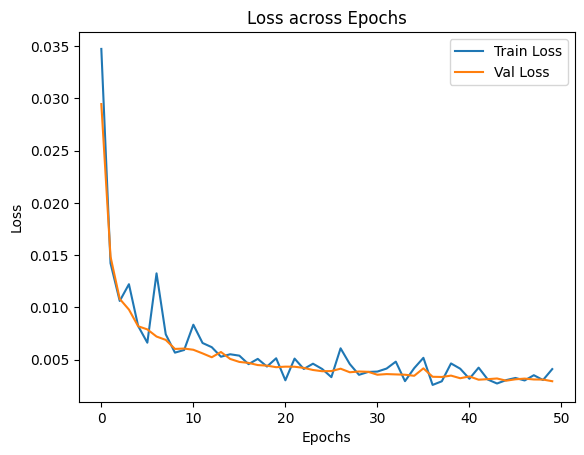

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9461388708630759


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 94.84%


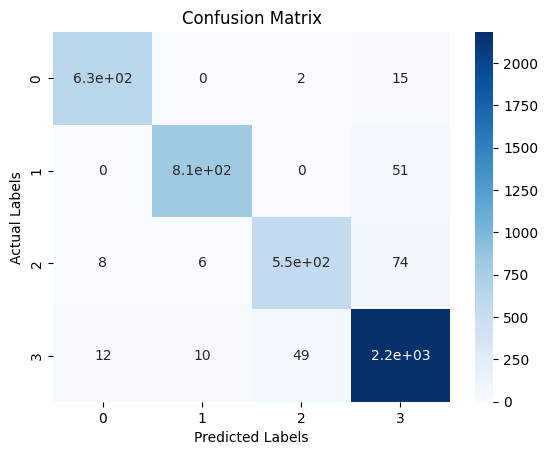

In [16]:
streamline_train_and_test(Autoencoder, tag="lstm_run_5", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0322, Val Loss: 0.0280
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0160, Val Loss: 0.0156
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0117, Val Loss: 0.0112
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0106, Val Loss: 0.0096
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0086, Val Loss: 0.0096
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0148, Val Loss: 0.0084
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0105, Val Loss: 0.0073
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0078, Val Loss: 0.0071
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0093, Val Loss: 0.0071
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0084, Val Loss: 0.0070
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0080, Val Loss: 0.0065
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0053, Val Loss: 0.0062
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0077, Val Loss: 0.0065
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0056, Val Loss: 0.0056
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0058, Val Loss: 0.0054
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0062, Val Loss: 0.0054
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0043, Val Loss: 0.0056
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0045, Val Loss: 0.0053
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0056, Val Loss: 0.0047
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0048, Val Loss: 0.0048
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0066, Val Loss: 0.0055
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0055, Val Loss: 0.0047
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0046, Val Loss: 0.0045
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0052, Val Loss: 0.0047
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0053, Val Loss: 0.0045
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0045, Val Loss: 0.0043
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0055, Val Loss: 0.0043
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0044, Val Loss: 0.0042
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0039, Val Loss: 0.0044
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0043, Val Loss: 0.0040
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0036, Val Loss: 0.0047
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0047, Val Loss: 0.0040
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0044, Val Loss: 0.0040
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0038, Val Loss: 0.0038
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0061, Val Loss: 0.0039
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0048, Val Loss: 0.0038
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0039, Val Loss: 0.0038
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0043, Val Loss: 0.0037
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0044, Val Loss: 0.0037
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0040, Val Loss: 0.0038
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0035, Val Loss: 0.0037
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0041, Val Loss: 0.0035
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0045, Val Loss: 0.0036
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0052, Val Loss: 0.0036
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0050, Val Loss: 0.0036
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0032, Val Loss: 0.0036
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0056, Val Loss: 0.0033
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0052, Val Loss: 0.0034
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0039, Val Loss: 0.0034
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0043, Val Loss: 0.0034


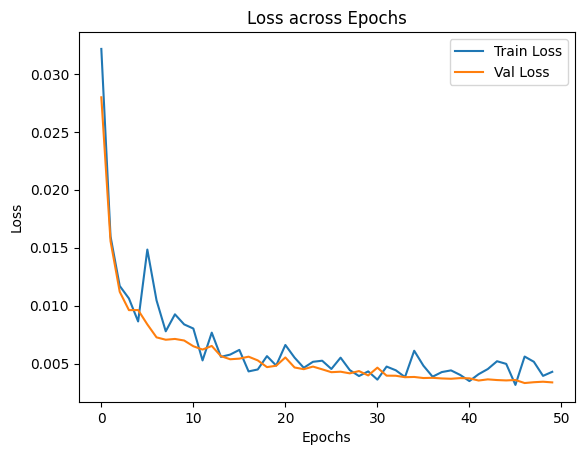

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9487345879299156


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 94.50%


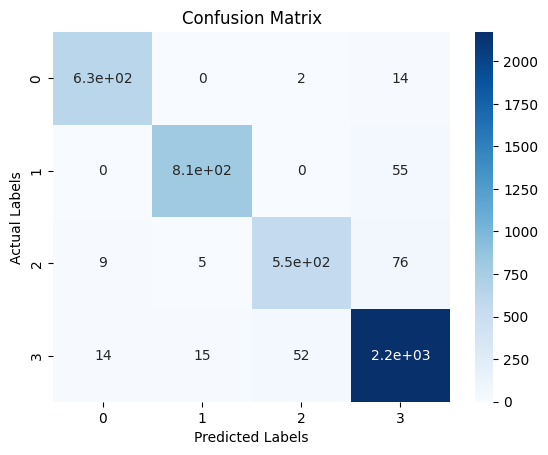

In [17]:
streamline_train_and_test(Autoencoder, tag="lstm_run_6", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0318, Val Loss: 0.0294
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0154, Val Loss: 0.0158
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0134, Val Loss: 0.0115
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0088, Val Loss: 0.0116
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0107, Val Loss: 0.0103
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0099, Val Loss: 0.0090
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0095, Val Loss: 0.0078
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0081, Val Loss: 0.0074
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0081, Val Loss: 0.0077
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0063, Val Loss: 0.0070
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0071, Val Loss: 0.0065
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0064, Val Loss: 0.0063
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0098, Val Loss: 0.0062
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0075, Val Loss: 0.0060
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0078, Val Loss: 0.0058
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0040, Val Loss: 0.0058
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0065, Val Loss: 0.0060
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0064, Val Loss: 0.0055
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0060, Val Loss: 0.0053
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0086, Val Loss: 0.0051
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0069, Val Loss: 0.0051
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0064, Val Loss: 0.0048
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0068, Val Loss: 0.0053
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0059, Val Loss: 0.0057
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0048, Val Loss: 0.0050
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0054, Val Loss: 0.0046
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0048, Val Loss: 0.0045
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0064, Val Loss: 0.0046
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0051, Val Loss: 0.0045
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0053, Val Loss: 0.0045
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0059, Val Loss: 0.0044
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0071, Val Loss: 0.0044
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0071, Val Loss: 0.0043
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0049, Val Loss: 0.0046
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0047, Val Loss: 0.0045
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0064, Val Loss: 0.0042
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0067, Val Loss: 0.0046
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0061, Val Loss: 0.0045
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0047, Val Loss: 0.0042
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0048, Val Loss: 0.0041
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0056, Val Loss: 0.0041
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0057, Val Loss: 0.0041
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0055, Val Loss: 0.0040
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0053, Val Loss: 0.0038
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0052, Val Loss: 0.0038
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0061, Val Loss: 0.0038
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0050, Val Loss: 0.0039
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0050, Val Loss: 0.0038
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0043, Val Loss: 0.0039
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0049, Val Loss: 0.0037


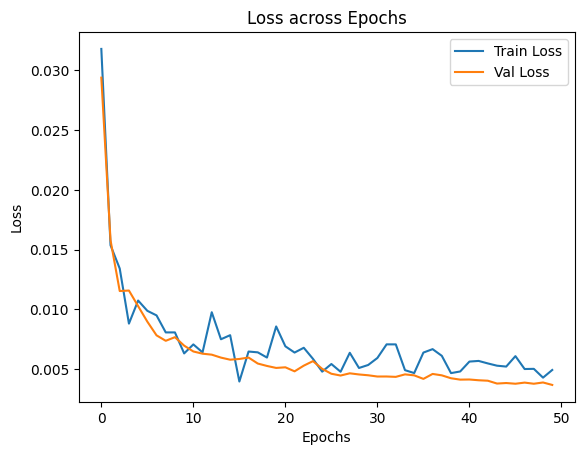

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9328358208955224


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 94.21%


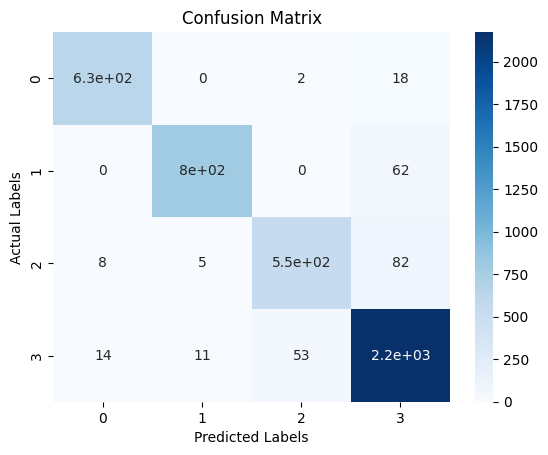

In [18]:
streamline_train_and_test(Autoencoder, tag="lstm_run_7", early_stop=True, dropout_rate=0.3, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.1026, Val Loss: 0.1366
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.3314, Val Loss: 0.1980
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.5876, Val Loss: 0.2760
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.2086, Val Loss: 0.2256
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.2472, Val Loss: 0.1562
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 2.0108, Val Loss: 1.1467
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.6401, Val Loss: 0.5322
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.8491, Val Loss: 0.8539
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.2609, Val Loss: 0.2346
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.5425, Val Loss: 0.4666
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.6734, Val Loss: 0.7270
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.8757, Val Loss: 0.9089
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.4049, Val Loss: 0.6217
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.5473, Val Loss: 0.5055
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 1.1240, Val Loss: 1.1041
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.3747, Val Loss: 0.4773
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.5369, Val Loss: 0.7627
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.7354, Val Loss: 1.2412
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.8337, Val Loss: 0.6665
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.2601, Val Loss: 0.3448
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 1.0553, Val Loss: 0.8071
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.9224, Val Loss: 1.0448
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.3154, Val Loss: 0.2510
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.7906, Val Loss: 0.5659
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.8292, Val Loss: 0.9513
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.8913, Val Loss: 1.1340
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.9541, Val Loss: 0.5454
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.3912, Val Loss: 0.2634
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 1.2211, Val Loss: 1.0133
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.3708, Val Loss: 0.3413
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.6564, Val Loss: 0.5617
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.7196, Val Loss: 0.5070
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.4044, Val Loss: 0.5121
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.8235, Val Loss: 0.8818
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.5518, Val Loss: 0.3740
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.6835, Val Loss: 0.7414
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.4805, Val Loss: 0.3320
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.9947, Val Loss: 1.0848
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.8449, Val Loss: 0.8425
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.5562, Val Loss: 0.7703
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 1.2995, Val Loss: 1.4496
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.5062, Val Loss: 0.5465
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.5025, Val Loss: 0.7322
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.3320, Val Loss: 0.4562
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 1.0001, Val Loss: 1.1628
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.8561, Val Loss: 1.0478
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 2.8224, Val Loss: 1.8495
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.3436, Val Loss: 0.4220
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.4786, Val Loss: 0.4912
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.3141, Val Loss: 0.4309


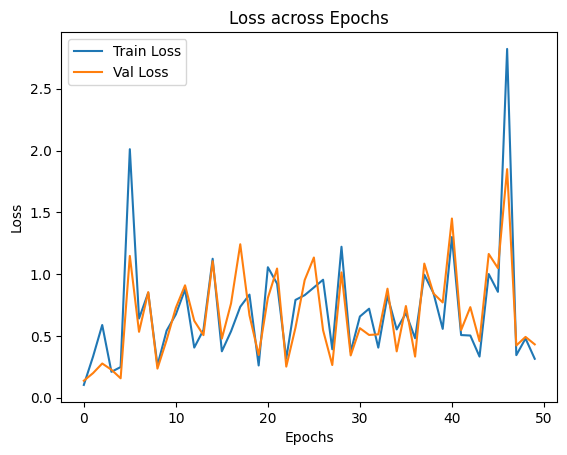

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.49059052563270605


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 51.15%


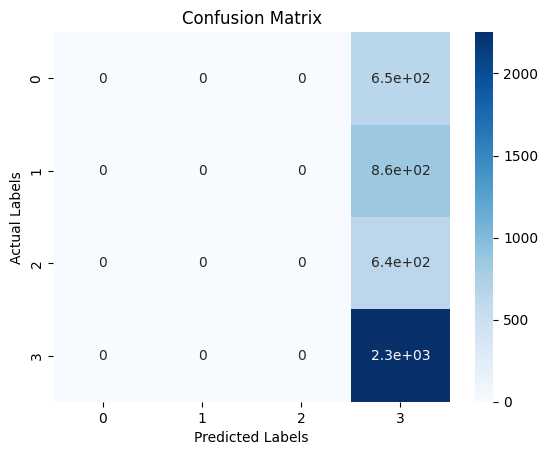

In [28]:
streamline_train_and_test(Autoencoder, tag="lstm_run_11", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.1)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0562, Val Loss: 0.0645
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0630, Val Loss: 0.0664
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0713, Val Loss: 0.0607
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0636, Val Loss: 0.0898
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0523, Val Loss: 0.0630
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0825, Val Loss: 0.0758
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0622, Val Loss: 0.0604
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0591, Val Loss: 0.0596
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0587, Val Loss: 0.0601
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0670, Val Loss: 0.0586
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0493, Val Loss: 0.0584
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0481, Val Loss: 0.0583
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0605, Val Loss: 0.0588
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0566, Val Loss: 0.0582
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0542, Val Loss: 0.0581
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0585, Val Loss: 0.0584
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0558, Val Loss: 0.0580
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0606, Val Loss: 0.0580
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0612, Val Loss: 0.0581
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0671, Val Loss: 0.0579
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0613, Val Loss: 0.0585
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0565, Val Loss: 0.0580
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0611, Val Loss: 0.0581
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0566, Val Loss: 0.0582
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0562, Val Loss: 0.0589
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0522, Val Loss: 0.0587
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0551, Val Loss: 0.0580
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0555, Val Loss: 0.0579
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0585, Val Loss: 0.0579
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0615, Val Loss: 0.0579
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0522, Val Loss: 0.0578
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0486, Val Loss: 0.0587
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0443, Val Loss: 0.0581
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0505, Val Loss: 0.0581
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0539, Val Loss: 0.0581
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0544, Val Loss: 0.0582
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0523, Val Loss: 0.0579
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0579, Val Loss: 0.0580
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0572, Val Loss: 0.0579
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0538, Val Loss: 0.0580
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0595, Val Loss: 0.0589
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0559, Val Loss: 0.0579
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0597, Val Loss: 0.0580
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0558, Val Loss: 0.0580
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0670, Val Loss: 0.0582
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0542, Val Loss: 0.0580
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0632, Val Loss: 0.0583
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0532, Val Loss: 0.0580
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0568, Val Loss: 0.0583
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0541, Val Loss: 0.0581


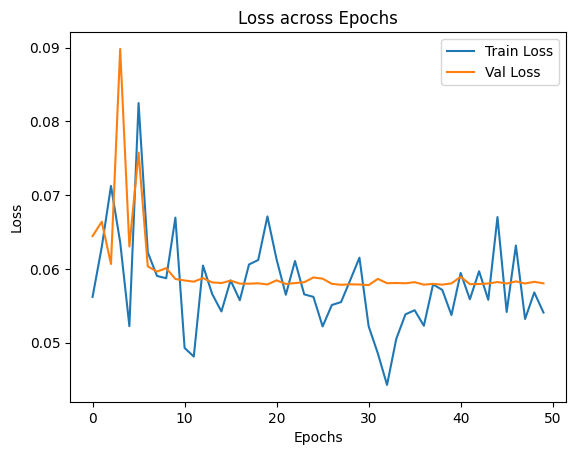

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.5012978585334199


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 51.15%


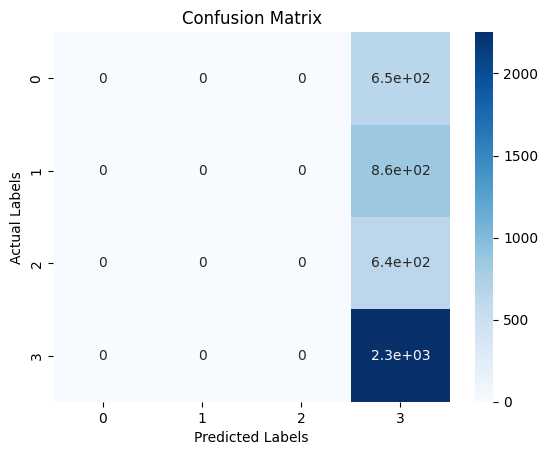

In [29]:
streamline_train_and_test(Autoencoder, tag="lstm_run_12", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.01)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0789, Val Loss: 0.0650
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0669, Val Loss: 0.0771
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0844, Val Loss: 0.0924
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0782, Val Loss: 0.0972
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0765, Val Loss: 0.1004
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.1238, Val Loss: 0.0841
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0719, Val Loss: 0.0713
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.1190, Val Loss: 0.0810
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0591, Val Loss: 0.0809
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0769, Val Loss: 0.0703
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.1059, Val Loss: 0.0621
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0984, Val Loss: 0.0713
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0690, Val Loss: 0.0649
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0994, Val Loss: 0.0716
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0672, Val Loss: 0.0911
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0884, Val Loss: 0.0733
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0685, Val Loss: 0.1092
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0760, Val Loss: 0.0919
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0723, Val Loss: 0.0734
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0651, Val Loss: 0.0744
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0679, Val Loss: 0.1706
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0855, Val Loss: 0.1388
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0863, Val Loss: 0.0732
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0863, Val Loss: 0.1308
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0890, Val Loss: 0.0898
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0685, Val Loss: 0.0686
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0696, Val Loss: 0.0739
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0645, Val Loss: 0.0905
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0749, Val Loss: 0.0699
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.1139, Val Loss: 0.0690
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0804, Val Loss: 0.0664
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0646, Val Loss: 0.0690
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0749, Val Loss: 0.0664
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0950, Val Loss: 0.0751
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0684, Val Loss: 0.1050
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0668, Val Loss: 0.0660
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0639, Val Loss: 0.0830
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0761, Val Loss: 0.0827
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0880, Val Loss: 0.0727
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0817, Val Loss: 0.0810
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0802, Val Loss: 0.1176
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0678, Val Loss: 0.0957
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0660, Val Loss: 0.0637
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.1051, Val Loss: 0.0766
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0675, Val Loss: 0.0629
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0666, Val Loss: 0.0634
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0672, Val Loss: 0.0717
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0734, Val Loss: 0.0621
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0887, Val Loss: 0.0701
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0632, Val Loss: 0.0710


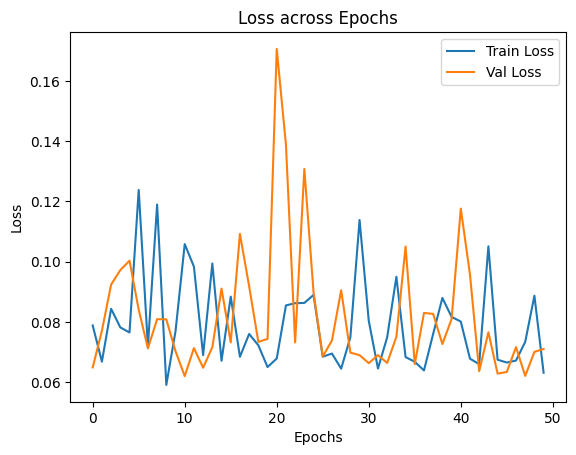

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.5042180402336145


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 51.15%


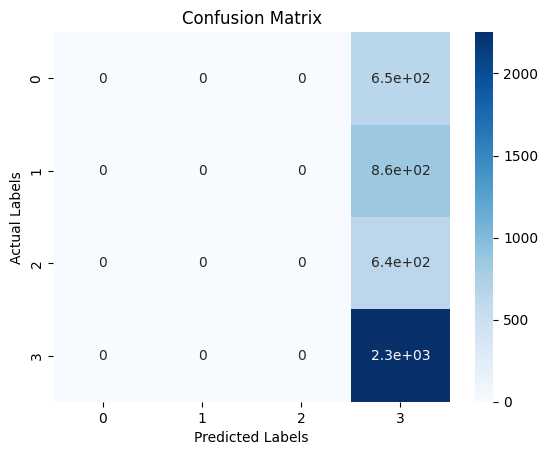

In [30]:
streamline_train_and_test(Autoencoder, tag="lstm_run_13", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.05)

In [19]:
# Bidirectional 2-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        # Concatenate Forward + Backward Pass - (seq_len, batch, num_directions * hidden_size)  
        encoded_x = (encoded_x[0, :, :] + encoded_x[1, :, :])
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0150, Val Loss: 0.0154
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0086, Val Loss: 0.0083
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0091, Val Loss: 0.0067
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0046, Val Loss: 0.0058
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0033, Val Loss: 0.0049
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0043, Val Loss: 0.0048
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0046, Val Loss: 0.0040
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0038, Val Loss: 0.0039
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0050, Val Loss: 0.0037
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0043, Val Loss: 0.0032
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0025, Val Loss: 0.0030
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0035, Val Loss: 0.0031
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0026, Val Loss: 0.0027
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0018, Val Loss: 0.0025
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0022, Val Loss: 0.0025
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0023, Val Loss: 0.0024
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0028, Val Loss: 0.0023
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0024, Val Loss: 0.0021
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0022, Val Loss: 0.0020
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0017, Val Loss: 0.0021
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0022, Val Loss: 0.0021
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0021, Val Loss: 0.0019
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0017, Val Loss: 0.0020
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0014, Val Loss: 0.0019
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0011, Val Loss: 0.0018
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0013, Val Loss: 0.0017
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0013, Val Loss: 0.0017
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0014, Val Loss: 0.0017
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0017, Val Loss: 0.0016
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0012, Val Loss: 0.0017
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0013, Val Loss: 0.0016
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0015, Val Loss: 0.0016
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0012, Val Loss: 0.0016
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0016, Val Loss: 0.0015
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0015, Val Loss: 0.0015
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0019, Val Loss: 0.0016
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0014, Val Loss: 0.0015
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0009, Val Loss: 0.0014
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0014, Val Loss: 0.0014
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0014, Val Loss: 0.0013
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0011, Val Loss: 0.0014
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0013, Val Loss: 0.0013
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0010, Val Loss: 0.0014
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0013, Val Loss: 0.0014
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0018, Val Loss: 0.0014
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0013, Val Loss: 0.0013
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0011, Val Loss: 0.0013
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0012, Val Loss: 0.0013
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0010, Val Loss: 0.0013
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0012, Val Loss: 0.0015


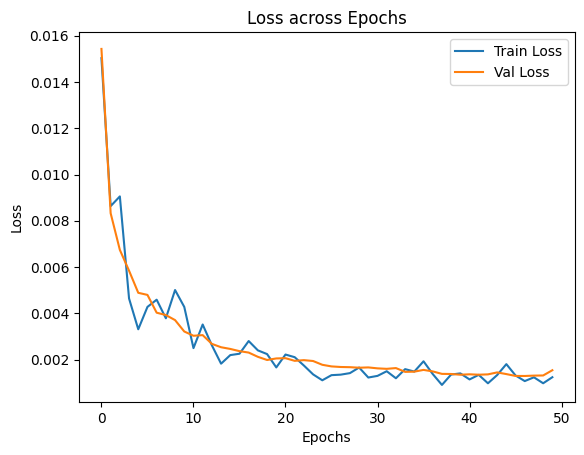

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9441920830629461


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 94.07%


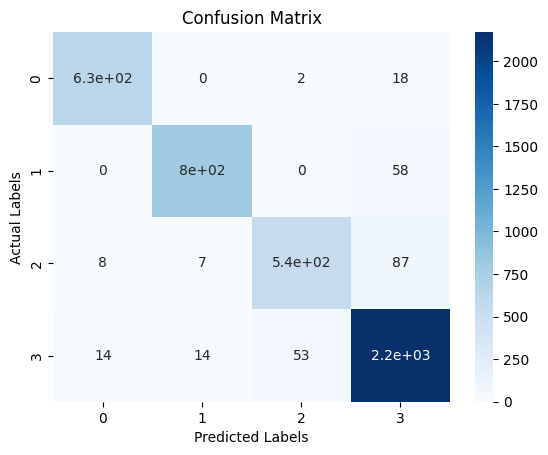

In [20]:
streamline_train_and_test(Autoencoder, tag="lstm_run_4", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0163, Val Loss: 0.0159
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0105, Val Loss: 0.0088
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0089, Val Loss: 0.0097
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0075, Val Loss: 0.0060
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0058, Val Loss: 0.0051
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0064, Val Loss: 0.0046
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0033, Val Loss: 0.0041
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0032, Val Loss: 0.0044
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0032, Val Loss: 0.0040
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0038, Val Loss: 0.0037
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0041, Val Loss: 0.0034
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0040, Val Loss: 0.0034
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0036, Val Loss: 0.0031
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0025, Val Loss: 0.0030
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0016, Val Loss: 0.0026
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0016, Val Loss: 0.0025
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0023, Val Loss: 0.0025
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0021, Val Loss: 0.0026
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0018, Val Loss: 0.0024
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0018, Val Loss: 0.0023
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0031, Val Loss: 0.0022
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0014, Val Loss: 0.0020
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0016, Val Loss: 0.0020
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0024, Val Loss: 0.0020
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0024, Val Loss: 0.0020
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0014, Val Loss: 0.0021
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0016, Val Loss: 0.0020
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0020, Val Loss: 0.0019
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0015, Val Loss: 0.0018
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0013, Val Loss: 0.0018
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0020, Val Loss: 0.0018
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0014, Val Loss: 0.0017
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0020, Val Loss: 0.0017
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0028, Val Loss: 0.0019
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0017, Val Loss: 0.0016
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0013, Val Loss: 0.0016
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0014, Val Loss: 0.0017
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0014, Val Loss: 0.0018
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0019, Val Loss: 0.0016
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0011, Val Loss: 0.0016
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0019, Val Loss: 0.0016
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0018, Val Loss: 0.0017
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0012, Val Loss: 0.0016
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0013, Val Loss: 0.0016
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0009, Val Loss: 0.0015
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0010, Val Loss: 0.0014
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0011, Val Loss: 0.0014
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0012, Val Loss: 0.0015
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0009, Val Loss: 0.0014
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0013, Val Loss: 0.0014


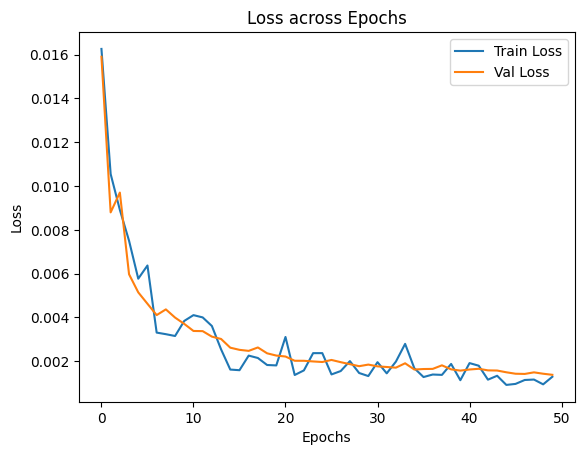

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9367293964957819


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 93.87%


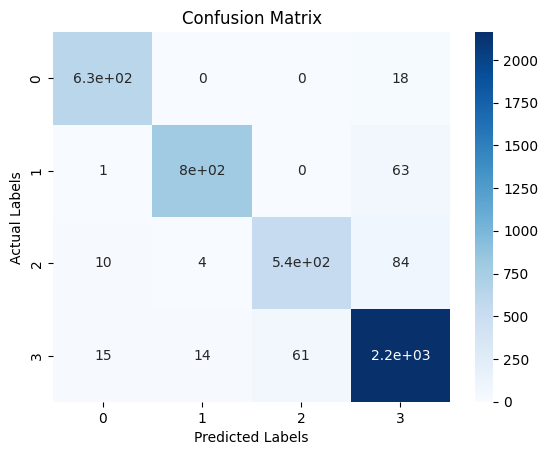

In [21]:
streamline_train_and_test(Autoencoder, tag="lstm_run_8", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0177, Val Loss: 0.0181
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0124, Val Loss: 0.0094
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0103, Val Loss: 0.0076
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0068, Val Loss: 0.0066
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0062, Val Loss: 0.0057
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0041, Val Loss: 0.0053
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0041, Val Loss: 0.0047
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0038, Val Loss: 0.0043
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0040, Val Loss: 0.0039
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0040, Val Loss: 0.0036
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0030, Val Loss: 0.0035
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0035, Val Loss: 0.0032
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0023, Val Loss: 0.0030
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0028, Val Loss: 0.0032
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0031, Val Loss: 0.0029
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0026, Val Loss: 0.0028
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0022, Val Loss: 0.0027
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0038, Val Loss: 0.0024
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0020, Val Loss: 0.0025
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0020, Val Loss: 0.0026
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0021, Val Loss: 0.0022
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0028, Val Loss: 0.0023
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0025, Val Loss: 0.0022
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0025, Val Loss: 0.0023
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0022, Val Loss: 0.0020
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0020, Val Loss: 0.0020
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0027, Val Loss: 0.0020
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0011, Val Loss: 0.0021
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0020, Val Loss: 0.0019
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0018, Val Loss: 0.0021
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0022, Val Loss: 0.0019
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0017, Val Loss: 0.0019
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0016, Val Loss: 0.0018
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0011, Val Loss: 0.0018
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0015, Val Loss: 0.0017
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0020, Val Loss: 0.0018
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0014, Val Loss: 0.0017
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0018, Val Loss: 0.0019
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0021, Val Loss: 0.0017
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0017, Val Loss: 0.0016
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0012, Val Loss: 0.0016
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0016, Val Loss: 0.0016
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0017, Val Loss: 0.0016
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0016, Val Loss: 0.0015
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0014, Val Loss: 0.0016
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0012, Val Loss: 0.0016
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0013, Val Loss: 0.0016
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0014, Val Loss: 0.0015
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0010, Val Loss: 0.0015
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0017, Val Loss: 0.0016


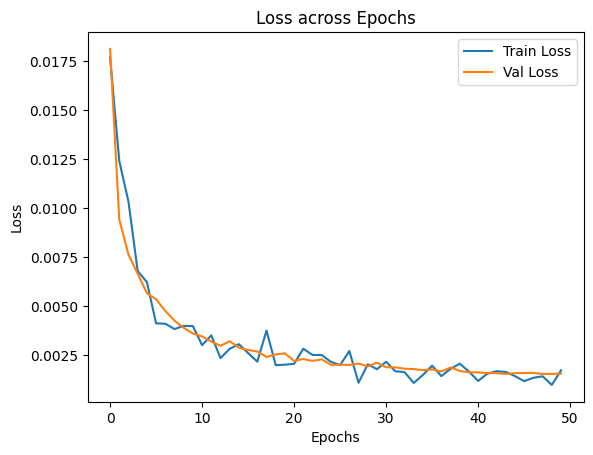

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9334847501622323


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 93.82%


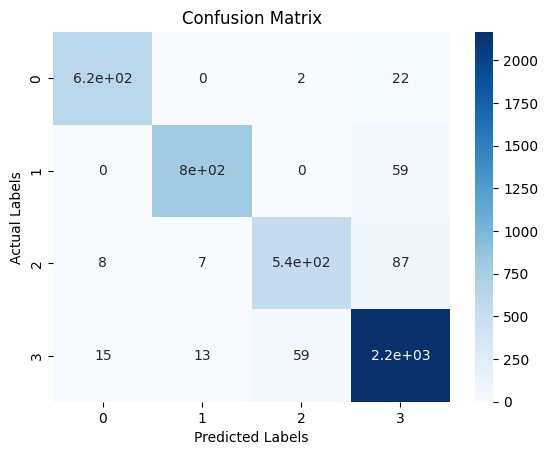

In [22]:
streamline_train_and_test(Autoencoder, tag="lstm_run_9", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0177, Val Loss: 0.0158
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0082, Val Loss: 0.0091
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0078, Val Loss: 0.0078
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0067, Val Loss: 0.0060
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0054, Val Loss: 0.0060
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0058, Val Loss: 0.0051
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0047, Val Loss: 0.0045
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0053, Val Loss: 0.0042
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0033, Val Loss: 0.0038
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0032, Val Loss: 0.0037
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0043, Val Loss: 0.0034
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0040, Val Loss: 0.0036
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0046, Val Loss: 0.0032
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0023, Val Loss: 0.0031
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0033, Val Loss: 0.0027
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0033, Val Loss: 0.0028
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0025, Val Loss: 0.0027
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0017, Val Loss: 0.0024
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0024, Val Loss: 0.0023
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0023, Val Loss: 0.0023
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0028, Val Loss: 0.0024
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0023, Val Loss: 0.0022
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0023, Val Loss: 0.0023
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0018, Val Loss: 0.0022
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0020, Val Loss: 0.0021
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0018, Val Loss: 0.0021
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0017, Val Loss: 0.0019
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0016, Val Loss: 0.0020
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0017, Val Loss: 0.0020
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0017, Val Loss: 0.0019
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0024, Val Loss: 0.0020
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0020, Val Loss: 0.0019
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0016, Val Loss: 0.0017
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0016, Val Loss: 0.0018
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0012, Val Loss: 0.0018
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0019, Val Loss: 0.0018
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0015, Val Loss: 0.0017
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0016, Val Loss: 0.0017
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0015, Val Loss: 0.0017
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0010, Val Loss: 0.0016
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0016, Val Loss: 0.0018
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0019, Val Loss: 0.0017
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0013, Val Loss: 0.0016
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0012, Val Loss: 0.0016
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0018, Val Loss: 0.0016
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0013, Val Loss: 0.0016
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0016, Val Loss: 0.0016
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0015, Val Loss: 0.0016
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0016, Val Loss: 0.0016
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0012, Val Loss: 0.0016


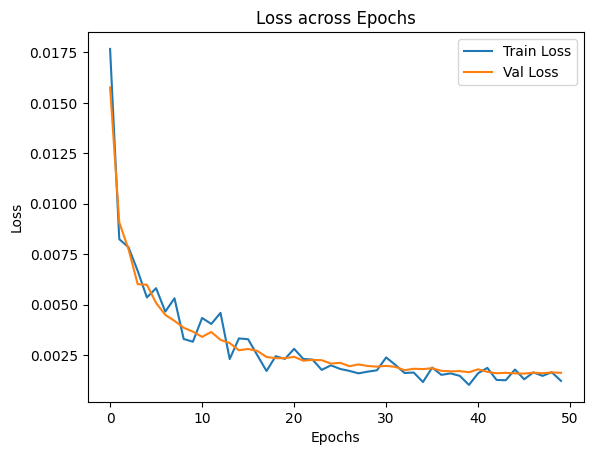

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9377027903958468


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 93.12%


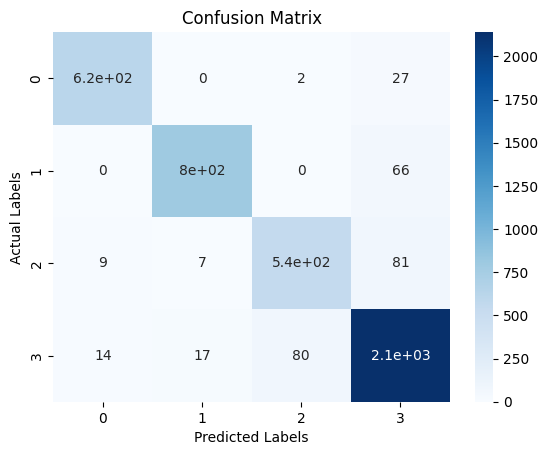

In [23]:
streamline_train_and_test(Autoencoder, tag="lstm_run_10", early_stop=True, dropout_rate=0.3, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0642, Val Loss: 0.1057
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.1620, Val Loss: 0.3081
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 1.4339, Val Loss: 1.0798
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.9027, Val Loss: 0.7510
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 1.3177, Val Loss: 0.9524
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.8069, Val Loss: 0.8912
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.5918, Val Loss: 0.4254
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 1.7106, Val Loss: 1.2241
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.3965, Val Loss: 0.5528
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 1.0740, Val Loss: 0.9563
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 2.4303, Val Loss: 2.1730
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.9330, Val Loss: 0.8778
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.4604, Val Loss: 0.4321
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.4949, Val Loss: 0.3109
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.6738, Val Loss: 0.3558
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.5149, Val Loss: 0.7485
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.8103, Val Loss: 0.5471
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 3.0022, Val Loss: 2.6885
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.2180, Val Loss: 0.2125
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.5461, Val Loss: 0.5893
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.7904, Val Loss: 0.4137
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 1.0228, Val Loss: 1.0773
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.3638, Val Loss: 0.2365
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 1.3827, Val Loss: 1.0610
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.6755, Val Loss: 1.3519
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.7621, Val Loss: 0.9102
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 2.0121, Val Loss: 2.1302
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.7528, Val Loss: 0.8578
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 1.2902, Val Loss: 1.4726
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 2.0810, Val Loss: 2.2273
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.8584, Val Loss: 0.7684
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.1554, Val Loss: 0.2303
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.3987, Val Loss: 0.8983
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.5622, Val Loss: 0.7466
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 1.6140, Val Loss: 1.5401
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.7791, Val Loss: 1.1162
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.2449, Val Loss: 0.3097
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 1.0923, Val Loss: 0.6362
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.8661, Val Loss: 0.9130
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.4074, Val Loss: 0.4403
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 1.1846, Val Loss: 1.0102
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.2900, Val Loss: 0.3980
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 1.0057, Val Loss: 1.2800
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.4695, Val Loss: 0.6875
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 1.3484, Val Loss: 2.1673
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 2.0341, Val Loss: 2.7559
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 1.2037, Val Loss: 1.1074
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.2905, Val Loss: 0.3192
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 1.0030, Val Loss: 1.4752
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.8362, Val Loss: 0.7117


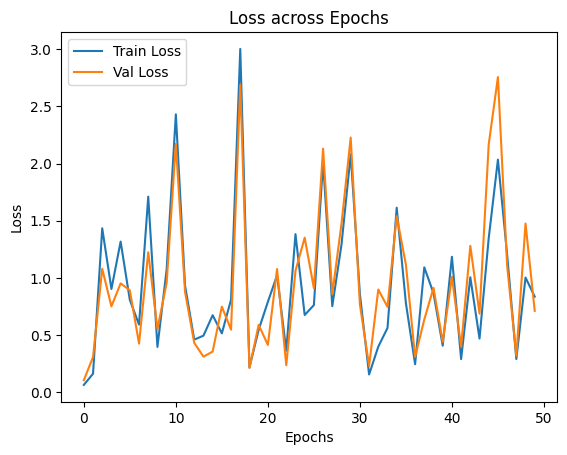

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.5074626865671642


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 51.15%


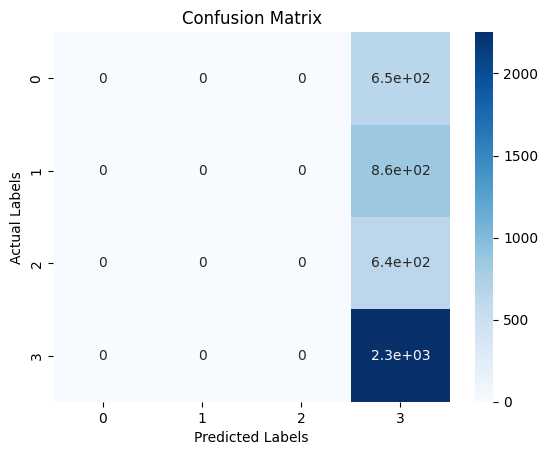

In [24]:
streamline_train_and_test(Autoencoder, tag="lstm_run_14", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.1)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0622, Val Loss: 0.0848
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0504, Val Loss: 0.0485
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0598, Val Loss: 0.0570
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0675, Val Loss: 0.0499
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0490, Val Loss: 0.0534
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0610, Val Loss: 0.0531
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0528, Val Loss: 0.0490
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0534, Val Loss: 0.0554
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0455, Val Loss: 0.0516
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0467, Val Loss: 0.0524
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0609, Val Loss: 0.0527
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0545, Val Loss: 0.0530
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0421, Val Loss: 0.0493
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0470, Val Loss: 0.0543
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0505, Val Loss: 0.0513
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0577, Val Loss: 0.0502
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0477, Val Loss: 0.0559
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0526, Val Loss: 0.0511
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0620, Val Loss: 0.0542
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0451, Val Loss: 0.0534
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0649, Val Loss: 0.0498
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0463, Val Loss: 0.0519
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0536, Val Loss: 0.0569
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0502, Val Loss: 0.0605
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0586, Val Loss: 0.0586
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0640, Val Loss: 0.0541
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0615, Val Loss: 0.0530
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0771, Val Loss: 0.0627
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0647, Val Loss: 0.0654
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0530, Val Loss: 0.0683
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0629, Val Loss: 0.0605
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0581, Val Loss: 0.0653
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0611, Val Loss: 0.0707
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0766, Val Loss: 0.0703
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0619, Val Loss: 0.0646
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0784, Val Loss: 0.0635
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0564, Val Loss: 0.0623
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0744, Val Loss: 0.0610
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0745, Val Loss: 0.0905
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0567, Val Loss: 0.0612
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0560, Val Loss: 0.0665
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0618, Val Loss: 0.0676
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0668, Val Loss: 0.0690
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0591, Val Loss: 0.0589
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0728, Val Loss: 0.0672
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0698, Val Loss: 0.0595
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0679, Val Loss: 0.0593
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0696, Val Loss: 0.0664
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0772, Val Loss: 0.0714
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0584, Val Loss: 0.0644


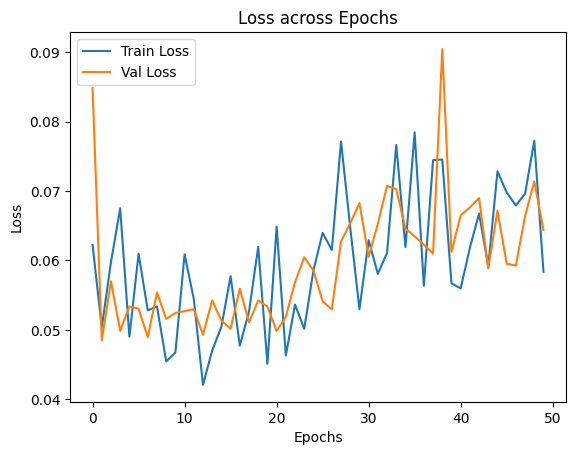

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.5577547047371837


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 54.92%


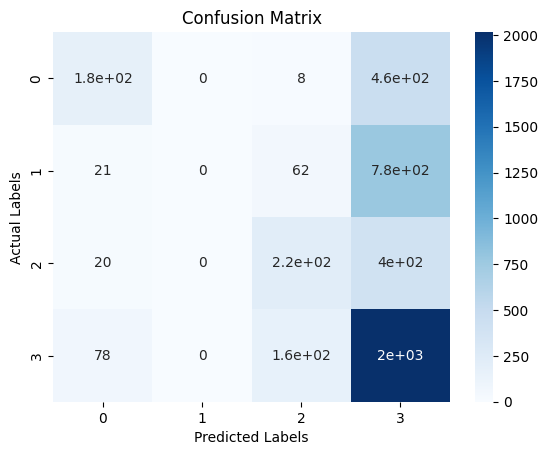

In [25]:
streamline_train_and_test(Autoencoder, tag="lstm_run_15", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.01)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.1624, Val Loss: 0.0900
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0949, Val Loss: 0.1328
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.3828, Val Loss: 0.3339
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.4622, Val Loss: 0.3238
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.2277, Val Loss: 0.2485
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.1840, Val Loss: 0.6028
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.2061, Val Loss: 0.2058
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.2140, Val Loss: 0.4520
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.2433, Val Loss: 0.1703
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.3401, Val Loss: 0.4266
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.3109, Val Loss: 0.1557
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.1378, Val Loss: 0.2165
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.2488, Val Loss: 0.3547
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.1745, Val Loss: 0.1340
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.2644, Val Loss: 0.2395
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.3053, Val Loss: 0.1401
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.1196, Val Loss: 0.1917
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.2347, Val Loss: 0.1572
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.1196, Val Loss: 0.1819
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.2109, Val Loss: 0.1762
Starting Epoch 21...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.2103, Val Loss: 0.2910
Starting Epoch 22...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.2697, Val Loss: 0.2206
Starting Epoch 23...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.2689, Val Loss: 0.3366
Starting Epoch 24...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.3353, Val Loss: 0.1463
Starting Epoch 25...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.1749, Val Loss: 0.3941
Starting Epoch 26...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.1426, Val Loss: 0.1191
Starting Epoch 27...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.1317, Val Loss: 0.1537
Starting Epoch 28...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.1767, Val Loss: 0.1599
Starting Epoch 29...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.1568, Val Loss: 0.3500
Starting Epoch 30...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.1073, Val Loss: 0.1644
Starting Epoch 31...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.2696, Val Loss: 0.3152
Starting Epoch 32...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.2322, Val Loss: 0.4057
Starting Epoch 33...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.1519, Val Loss: 0.1516
Starting Epoch 34...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.2237, Val Loss: 0.2058
Starting Epoch 35...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.1715, Val Loss: 0.1490
Starting Epoch 36...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.3044, Val Loss: 0.2394
Starting Epoch 37...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0944, Val Loss: 0.1410
Starting Epoch 38...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.2356, Val Loss: 0.2241
Starting Epoch 39...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.1701, Val Loss: 0.1272
Starting Epoch 40...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.3215, Val Loss: 0.3917
Starting Epoch 41...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.2958, Val Loss: 0.2107
Starting Epoch 42...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.2039, Val Loss: 0.2604
Starting Epoch 43...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.1209, Val Loss: 0.3336
Starting Epoch 44...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.1878, Val Loss: 0.1902
Starting Epoch 45...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.1296, Val Loss: 0.2057
Starting Epoch 46...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.2827, Val Loss: 0.1678
Starting Epoch 47...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.2154, Val Loss: 0.3267
Starting Epoch 48...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.8235, Val Loss: 0.3098
Starting Epoch 49...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.1768, Val Loss: 0.1292
Starting Epoch 50...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.3121, Val Loss: 0.2446


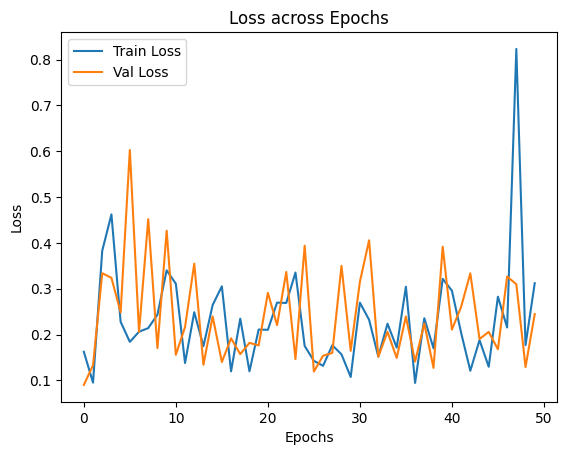

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.4889682024659312


  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)
Accuracy: 51.15%


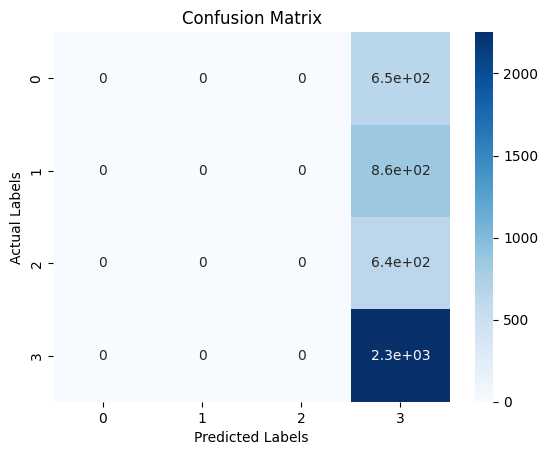

In [26]:
streamline_train_and_test(Autoencoder, tag="lstm_run_16", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.05)